In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Root finding

We want to find the value of $x$ such that $f(x) = 0$, for a general function $f(x)$.  This is the *root-finding* problem.

There are lots of different methods for finding roots.  We'll look at 2.

Let's start by trying to find the root of 

$$f(x) = \frac{1}{2} x^3 + \frac{\pi}{3}x + 2$$



In [42]:
def f(x):
    return 0.5*x**3 + np.pi/3 * x + 2

## Bisection

Let's start by plotting the function&mdash;we already have a decision to make.  We want to pick a range where we expect there to be a root.  So we will make a somewhat generous range.

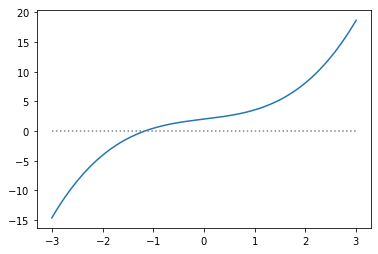

In [45]:
x = np.linspace(-3, 3, 1000)

fig = plt.figure()
ax = fig.add_subplot(111)

# plot our function
ax.plot(x, f(x))

# also plot y = 0, so we can see visually where the root lies
ax.plot(x, 0*x, linestyle=":", color="0.5")

Notice from this that the function crosses $y = 0$ near $x = -1$.  So just from the graph we have an approximation of the root.

But also notice that to the left of the root, $f(x) < 0$, and to the right of the root, $f(x) > 0$.  

So we can locate the root by looking for the region where $f(x)$ changes sign.  This is what bisection does&mdash;we pick an interval where we expect there to be a root and we narrow the interval by looking for the half-interval where $f(x)$ still changes sign.

Looking at the plot, we expect that the root lies between $[-2, -1]$&mdash;we'll call these the left and right points $x_l$ and $x_r$.

We can be sure by looking at the function values at those two points and checking if it indeed changes sign.

In [46]:
xl = -2
xr = -1

print(f(xl), f(xr))

-4.094395102393195 0.45280244880340237


It does!.  Now we can try to narrow the range.  For the bisection method, we'll look at the point in the middle (we'll call that $x_m$):

In [47]:
xm = 0.5 * (xl + xr)
print(f(xm))

-1.2582963267948966


$f(x_m) < 0$ just like $f(x_l)$, therefore, it must be the case that that our root, $x_0 \in [x_m, x_r]$.

So we now have cut the range in half.  We can then repeat this process, each time cutting the range where the root lies in half.  Once the interval containing the root is small enough (e.g., the width is less than the error with which we want to know the root), then we stop.

Let's code this idea up

In [49]:
def bisect(xl, xr, func, tol=1.e-8):
    """find the zero of func(x) in the interval [xl, xr]"""
    
    # first check if there is a root in the interval
    fl = func(xl)
    fr = func(xr)
    
    if fl * fr > 0:
        print("no root in the interval")
        return None
    
    # now setup our iteration loop.  We will keep looping until
    # the relative error is < tol
    err = 1.e10
    xm = 0.5 * (xl + xr)

    while err > tol:
        fm = func(xm)
        
        if fl*fm > 0:
            # the root is in the right half of the interval
            xl = xm
            fl = fm
        else:
            # the root is in the left half of the interval
            xr = xm
            fr = fm
        
        xm = 0.5 * (xl + xr)
        err = np.abs(xr - xl) / np.abs(xm)
        
    return xm

Now we can call it by giving it a range and the function we wish to zero

In [50]:
x0 = bisect(-2, -1, f, tol=1.e-10)

Did we get it right?  We can evaluate $f(x)$ at $x_0$:

In [51]:
f(x0)

6.193801027620793e-11

That's pretty close to 0!

Bisection convergece slowly&mdash;each iteration cuts the interval in half, so a lot of iterations may be needed to find the zero to the accuracy you want.

<div class="alert alert-block alert-info">

**Exercise:**

Consider the function 

$$g(x) = x^2$$

What happens when you try to use bisection on this? why?
    
</div>

In [52]:
def g(x):
    return x**2

bisect(-1, 1, g)

no root in the interval


Look at the function: there is no change in sign, even though there is a root at $x = 0$.  Bisection cannot find the root in this case.

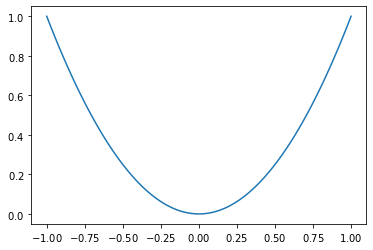

In [53]:
x = np.linspace(-1, 1, 100)
plt.plot(x, g(x))

## Newton-Raphson

The Newton-Raphson approach will often converge faster than bisection.  Instead of starting with a bracket containing the root, you start with an initial guess for the root, $x_0$.  We can then Taylor-expand around our guess:

$$f(x_0 + \delta x) = f(x_0) + f^\prime(x_0) \delta x + \mathcal{O}(\delta x^2)$$

Here, $\delta x$ is the correction to $x_0$ that gives us our root, i.e., $f(x_0 + \delta x) = 0$.

If our initial guess is good, then $\delta x$ is small, and we can neglect the higher-order terms in the expansion, and we have:

$$f(x_0 + \delta x) \approx f(x_0) + f^\prime(x_0) \delta x = 0$$

Solving for our correction, we have:

$$\delta x = -\frac{f(x_0)}{f^\prime(x_0)}$$

We can correct our initial guess: $x_0 \rightarrow x_0 + \delta x$ and repeat the process until $|\delta x| \ll |x_0|$.

One complication compared with bisection is that we need the derivative, $f^\prime(x)$ now.  Usually we'll want to provide the analytic derivative (but if needed, we could do a difference approximation).

We can understand Newton's method graphically as follows.  At each iteration, we have a guess for the root.  We follow the slope of the function, $f^\prime$ from that guess to where the slope intercepts the x-axis.  The x-intercept of the slope becomes our new guess and we repeat.  

For our function, starting with $x_0 = 3$, this looks like:

![Newton iter 0](newton_00.png)

The function evaluated at our initial guess, $f(x_0)$ is labeled `0`.  We look at the derivatve there and follow it down to the x-axis and get a new guess for the root (which we mark with a red "x").

Then we repeat, starting with this new guess:

![Newton iter 1](newton_01.png)

and again:

![Newton iter 2](newton_02.png)

Already in this 3rd iteration our new estimate for the root is quite good.

To code this up, we need to provide the derivative of our function above

In [54]:
def fprime(x):
    return 1.5*x**2 + np.pi/3.0

In [59]:
def newton(x0, func, funcprime, tol=1.e-8):
    """find the root of func(x) using Newton's method, taking
    x0 as an initial guess"""
    
    err = 1.e10
    
    while err > tol:
        dx = -func(x0) / funcprime(x0)
        x0 += dx
        
        # be careful about dividing by 0 for |x| ~ 0
        if np.abs(x0) < tol:
            err = np.abs(dx)
        else:
            err = np.abs(dx) / np.abs(x0)
        
    return x0

Let's start with $x_0 = 3$, just like the figures above:

In [60]:
x0 = 3
newton(x0, f, fprime)

-1.1615652985548652

<div class="alert alert-block alert-info">

**Exercise:**

Following up on the previous exercise.  Try finding the root of 
    
$$g(x) = x^2$$
    
using Newton's method.  How many iterations are needed to reach your error?
    
</div>

In [61]:
def gprime(x):
    return 2*x

x0 = 3
newton(x0, g, gprime)

5.587935447692871e-09

What about multiple roots?  Newton's method takes a single initial guess and it (may) converge to a single root.  By changing the initial guess, we might converge to a different root (if one exists).

Consider the following function:

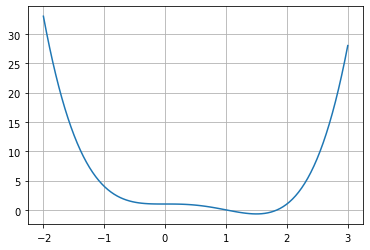

In [62]:
def h(x):
    return x**4 - 2*x**3 + 1

def hprime(x):
    return 4*x**3 - 6*x**2

x = np.linspace(-2,3,100)
plt.plot(x, h(x))
plt.grid()

<div class="alert alert-block alert-info">

**Exercise:**
    
There are 2 real roots.  Find both using Newton's method.
    
</div>